In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import spacy
import random

from IPython.core.display import display
from spacy.training import Example
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL
from sklearn.model_selection import train_test_split

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

## 数据和模型准备

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


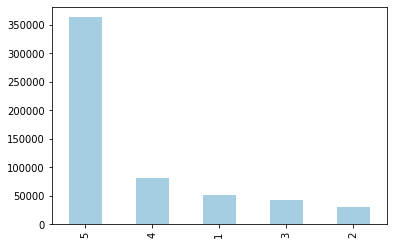

In [2]:
reviews_df=pd.read_csv('data/Reviews.csv')
print(reviews_df.shape)
display(reviews_df.head(5))

# 评分分布
ax=reviews_df.Score.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

(568454, 2)


,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


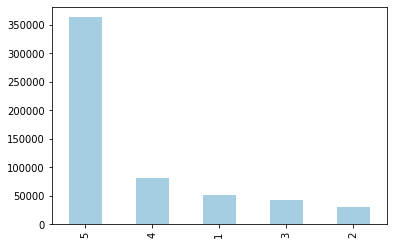

In [3]:
reviews_df = reviews_df[['Text','Score']].dropna()
print(reviews_df.shape)
display(reviews_df.head(5))

# 评分分布
ax=reviews_df.Score.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


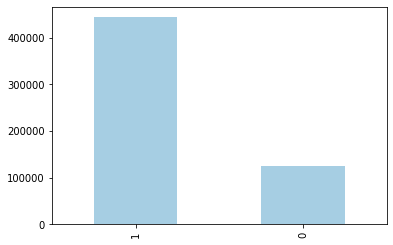

In [4]:
reviews_df.loc[reviews_df.Score<=3, 'Score']=0
reviews_df.loc[reviews_df.Score>3, 'Score']=1
display(reviews_df.head(5))

ax=reviews_df.Score.value_counts().plot(kind='bar',
colormap='Paired')
plt.show()

In [5]:
print('-'*25, '创建初始模型', '-'*25)

spacy.prefer_gpu()  # 这句代码必须在load之前调用
nlp = spacy.load("en_core_web_md")
config = {
    "threshold": 0.5,
    "model": DEFAULT_MULTI_TEXTCAT_MODEL
}
textcat = nlp.add_pipe("textcat_multilabel", config=config)
textcat.add_label("POS")
textcat.add_label("NEG")


print('-'*25, '生成训练测试数据', '-'*25)
examples = []
for index, row in reviews_df.sample(40000).iterrows():
    text = row["Text"]
    rating = row["Score"]
    label = {"POS": True, "NEG": False} if rating == 1 else {"NEG": True, "POS": False}
    examples.append(Example.from_dict(nlp.make_doc(text), {"cats": label})) 
    
print(f'len(examples)={len(examples)}')
    
train_examples, test_examples = train_test_split(examples,  
                                                 test_size=0.2, 
                                                 random_state=202109)    
print(f'len(train_examples)={len(train_examples)}')
print(f'len(test_examples)={len(test_examples)}')

------------------------- 创建初始模型 -------------------------
------------------------- 生成训练测试数据 -------------------------
len(examples)=40000
len(train_examples)=32000
len(test_examples)=8000


## 训练

In [6]:
def get_scores(nlp, examples, metrics=['cats_macro_auc', 'cats_macro_p', 'cats_macro_r', 'cats_macro_f']):
    scores = nlp.evaluate(examples)
    # 以下代码，效果完全相同
    # scorer = Scorer()
    # predicted_examples = [Example(nlp(example.predicted.text), example.reference)  
    #                       for example in examples]        
    # scores = scorer.score(predicted_examples)
    if isinstance(metrics[0], tuple):
        metrics = [metric for metric, _ in metrics]     
    scores = {metric:value  for metric, value in scores.items() if metric in metrics}
    return scores

def get_score_text(metrics=['cats_macro_auc', 'cats_macro_p', 'cats_macro_r', 'cats_macro_f']):    
    def get_text(scores):
        score_texts = [f'{display}:{round(scores[metric], 3):>5}' for metric, display in metrics]
        return ', '.join(score_texts) 
    
    if isinstance(metrics[0], str):
        metrics = [(metric, metric) for metric in metrics] 
    return get_text

def train(nlp, textcat, train_examples, test_examples, epochs, best_model_path, 
          metrics, best_metric, dropout=0.0, ):
    textcat.initialize(lambda: train_examples, nlp=nlp)
    score_text_fun = get_score_text(metrics)

    with nlp.select_pipes(enable="textcat_multilabel"):  
        optimizer = nlp.resume_training()
        best_metric_value = None    
        for itn in range(epochs):
            losses = {}        
            random.shuffle(train_examples)
            for batch in spacy.util.minibatch(train_examples, size=8):
                nlp.update(batch, losses=losses, drop=dropout) 

            train_scores = get_scores(nlp, train_examples, metrics)
            test_scores = get_scores(nlp, test_examples, metrics)
            metric_value = test_scores[best_metric]

            loss = losses['textcat_multilabel']    
            print((f"{itn+1:>2}/{epochs} "  
                   f"train=(loss:{round(loss, 3):>5}, {score_text_fun(train_scores)})"
                   f" test=({score_text_fun(test_scores)})"))
            if best_metric_value is None or metric_value > best_metric_value:
                best_metric_value = metric_value        
                nlp.to_disk(best_model_path)

print('-'*25, '训练', '-'*25)
# ! mkdir output/first_classification                
best_model_path='output/first_classification/best'  
metrics = [('cats_macro_auc', 'auc'), ('cats_macro_p', 'p'), 
           ('cats_macro_r', 'r'), ('cats_macro_f', 'f')]
train(nlp, textcat, train_examples, test_examples, epochs=10, best_model_path=best_model_path, 
      metrics=metrics, best_metric='cats_macro_auc', dropout=0.5)

------------------------- 训练 -------------------------
 1/10 train=(loss:15.891, auc:0.948, p:0.898, r:0.834, f: 0.86) test=(auc:0.922, p: 0.85, r:0.774, f:0.803)
 2/10 train=(loss:8.787, auc:0.969, p:0.932, r:0.899, f:0.914) test=(auc:0.929, p: 0.86, r: 0.81, f:0.831)
 3/10 train=(loss:6.489, auc:0.978, p:0.955, r:0.912, f:0.931) test=(auc:0.932, p:0.877, r:0.798, f:0.828)
 4/10 train=(loss:5.119, auc:0.982, p:0.962, r:0.951, f:0.957) test=(auc: 0.93, p:0.852, r:0.831, f:0.841)
 5/10 train=(loss: 4.11, auc:0.985, p:0.975, r:0.948, f:0.961) test=(auc:0.925, p:0.873, r:  0.8, f:0.829)
 6/10 train=(loss:3.414, auc:0.987, p:0.977, r:0.968, f:0.972) test=(auc:0.929, p:0.853, r:0.828, f:0.839)
 7/10 train=(loss:2.894, auc:0.989, p:0.984, r:0.972, f:0.978) test=(auc:0.922, p:0.854, r:0.812, f: 0.83)
 8/10 train=(loss:2.502, auc: 0.99, p:0.986, r:0.978, f:0.982) test=(auc:0.923, p:0.851, r:0.824, f:0.837)
 9/10 train=(loss:2.137, auc:0.991, p:0.988, r:0.979, f:0.984) test=(auc:0.922, p:0.854,

## 评估和预测

In [7]:
spacy.prefer_gpu()  
nlp = spacy.load(best_model_path)

metrics=['cats_macro_auc', 'cats_micro_p', 'cats_macro_p', 
         'cats_micro_r', 'cats_macro_r', 'cats_micro_f', 'cats_macro_f']
metrics = [(metric, metric[5:]) for metric in metrics]
train_scores = get_scores(nlp, train_examples, metrics)
test_scores = get_scores(nlp, test_examples, metrics)
score_text_fun=get_score_text(metrics)

print(f"train=({score_text_fun(train_scores)}")
print(f" test=({score_text_fun(test_scores)}")

train=(macro_auc:0.978, micro_p:0.955, macro_p:0.955, micro_r:0.956, macro_r:0.912, micro_f:0.956, macro_f:0.931
 test=(macro_auc:0.932, micro_p:0.894, macro_p:0.877, micro_r:0.895, macro_r:0.798, micro_f:0.895, macro_f:0.828


In [8]:
def show_results(nlp, texts):
    docs = list(nlp.pipe(texts))
    for doc in docs:
        print('-'*25, doc.cats,'-'*25)
        print(doc.text)

texts = [
    "This is the best food I ever ate",
    "This food is so bad"
]   
   
show_results(nlp, texts) 

------------------------- {'POS': 0.9865200519561768, 'NEG': 0.013627051375806332} -------------------------
This is the best food I ever ate
------------------------- {'POS': 0.4325401186943054, 'NEG': 0.5881369113922119} -------------------------
This food is so bad


In [9]:
sample_index = np.random.randint(0, len(test_examples), 3)
for i in sample_index:
    example = test_examples[i] 
    print('='*40, i, '='*40)
    doc = nlp(example.predicted.text)
    print(example.predicted.text)
    print('-'*25, f'predicted:{doc.cats}', '-'*25)
    print('-'*25, f'reference: {example.reference.cats}', '-'*25)

======================================== 4457 ========================================
nice natural choice for treats i have bostons and chinese cresteds so the size of the treat was good and even could be split<br />if desired with ease
------------------------- predicted:{'POS': 0.9447638392448425, 'NEG': 0.055935949087142944} -------------------------
------------------------- reference: {'POS': True, 'NEG': False} -------------------------
======================================== 6004 ========================================
the more i drink this coffee the less i like it.<br />unless you're mixing it with lots of sugar and milk, it's harsh and acidic (in my opinion).<br />but the price is great, isn't it?<br />i'm currently looking for alternatives.....
------------------------- predicted:{'POS': 0.882432758808136, 'NEG': 0.10806461423635483} -------------------------
------------------------- reference: {'NEG': True, 'POS': False} -------------------------
=======================